In [1]:
import json
import os
from collections import defaultdict
from os import path as op
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from mne import EvokedArray
from mne.stats import f_mway_rm, f_threshold_mway_rm, permutation_cluster_1samp_test
from numpy.lib.npyio import load
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from vr2fem_analyses import helpers
from vr2fem_analyses.staticinfo import COLORS, CONFIG, PATHS

In [114]:
def load_decod_res_per_viewcond(
    sub_list_str,
    conditions,
    vc_list=[],
    scoring="roc_auc_ovr",
):
    data_dict = dict()

    if len(vc_list) == 0:
        vc_list = [""]

    paths = PATHS()

    contrast_str = "_vs_".join(conditions)

    for vc in vc_list:
        data_dict[vc] = dict(scores=[], times=[])
        for subID in sub_list_str:
            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                "ET",
                vc,
                contrast_str,
                scoring,
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[vc]["scores"].append(np.mean(scores_, axis=0))

            if len(data_dict[vc]["times"]) == 0:
                data_dict[vc]["times"] = np.load(str(fname)[:-4] + "__times" + ".npy")

        data_dict[vc]["scores"] = np.array(data_dict[vc]["scores"])

    return data_dict


def load_decod_res_per_contrast(
    sub_list_str,
    contrasts,
    scorings,
    vc_list=[],
):
    data_dict = dict()

    if len(vc_list) == 0:
        vc_list = [""] * len(contrasts)
    elif len(vc_list) == 1:
        vc_list = vc_list * len(contrasts)
    elif len(vc_list) != len(contrasts):
        raise ValueError("vc_list must be same length as contrasts")

    if len(scorings) == 1:
        scorings = scorings * len(contrasts)
    elif len(scorings) != len(contrasts):
        raise ValueError("scorings must be same length as contrasts")

    paths = PATHS()

    contrast_str_list = ["_vs_".join(c) for c in contrasts]

    times = []
    for idx, c in enumerate(contrast_str_list):
        data_dict[c] = dict(scores=[], times=[])
        for subID in sub_list_str:
            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                "ET",
                vc_list[idx],
                c,
                scorings[idx],
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[c]["scores"].append(np.mean(scores_, axis=0))

            if len(times) == 0:
                times = np.load(str(fname)[:-4] + "__times" + ".npy")
            data_dict[c]["times"] = times

        data_dict[c]["scores"] = np.array(data_dict[c]["scores"])

    return data_dict


def plot_score_per_factor(
    factor,
    data,
    scoring="accuracy",
    sign_clusters=[],
    p_lvl=0.05,
    chancelvl=0.5,
    ylims=None,
    xlims=None,
    ax=None,
    n_boot=1000,
    palette=None,
):
    if palette is None:
        colors = COLORS()
        palette = colors.COLDICT

    sns.lineplot(
        x="time",
        y="score",
        hue=factor,
        data=data,
        n_boot=n_boot,
        palette=palette,
        ax=ax,
        linewidth=1.5,
        legend=False,
        errorbar="se",
    )
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=xlims, ylim=ylims)
    if scoring == "roc_auc":
        scoring_str = "ROC AUC"
    else:
        scoring_str = scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel("Time (s)")

    ax.text(x=1.0, y=chancelvl + 0.001, s="chance", ha="right")

    palette["diff"] = "red" if "red" not in palette.values() else "pink"

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.vlines(
        (0),
        ymin=ylims[0],
        ymax=ylims[1],
        linestyles="dashed",
        linewidth=0.5,
        color="black",
    )
    ax.hlines(
        chancelvl,
        xmin=xlims[0],
        xmax=xlims[1],
        linewidth=0.5,
        color="black",
    )
    p_lvl_str = "$p$ < ." + str(p_lvl).split(".")[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = palette[key.lower()]
            for sc in sign_clusters[key.lower()]:
                xmin = sc[0]
                xmax = sc[-1]
                y_ = ylims[0] + (0.02 - ((i + 1) * 0.025) * np.ptp(ylims))
                ax.hlines(
                    y_,
                    xmin=xmin,
                    xmax=xmax,
                    color=col,
                    label=p_lvl_str,
                )
            if i == 0 & len(sign_clusters[key.lower()]) > 0:
                ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            y_ = ytick_range[0] + 0.05 * np.ptp(ytick_range)
            ax.hlines(
                y_,
                xmin=xmin,
                xmax=xmax,
                color="purple",
                label=p_lvl_str,
            )
        if len(sign_clusters) > 0:
            ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters))
    # ax.legend(handles=handles[1:n_sgn_clu+1], labels=labels[1:n_sgn_clu+1])


def run_cbp_test(data, tail=0):
    # number of permutations to run
    n_permutations = 10000
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = tail  # 1 or -1 for one-sided test, 0 for two-sided

    config = CONFIG()

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.N_JOBS,
        verbose=False,
        tail=tail,
        step_down_p=0.0005,
        adjacency=connectivity,
        n_permutations=n_permutations,
        seed=42,
        out_type="mask",
    )

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return T_obs, clusters, cluster_p_values


def prep_and_plot_from_data(
    data_dict, subsets, ax, chancelvl=0.25, ylims=(0.2, 0.32), scoring="roc_auc", palette=None
):
    # Prepare data for plotting with seaborn:
    results_df_list = list()
    for vc in subsets:
        times = data_dict[vc]["times"]
        acc = np.asarray(data_dict[vc]["scores"])
        acc_df = pd.DataFrame(acc)
        acc_df.columns = times
        df = acc_df.melt(var_name="time", value_name="score")  # put into long format
        df["vc"] = vc
        results_df_list.append(df)
    data_plot = pd.concat(results_df_list)

    sign_cluster_times = {}
    # run CBP to find differences from chance:
    for vc in subsets:
        data = np.asarray(data_dict[vc]["scores"]) - chancelvl
        t_values, clusters, p_values = run_cbp_test(data, tail=1)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times[vc] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]

    if len(subsets) == 2:
        # run CBP to find difference between conditions:
        data = np.asarray(data_dict[subsets[0]]["scores"]) - np.asarray(data_dict[subsets[1]]["scores"])
        t_values, clusters, p_values = run_cbp_test(data, tail=0)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times["diff"] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]
        if len(sign_cluster_times["diff"]) > 0:
            helpers.print_msg("Found significant difference between conditions! Do you see that?")
    else:
        sign_cluster_times["diff"] = []
        print(
            "Not checking for difference between conditions (only implemented \
        for 2 groups)."
        )

    # Plot it:

    plot_score_per_factor(
        factor="vc",
        data=data_plot.reset_index(),
        scoring=scoring,
        sign_clusters={ecc: sign_cluster_times[ecc] for ecc in subsets + ["diff"]},
        p_lvl=p_val_cbp,
        chancelvl=chancelvl,
        ylims=ylims,
        xlims=(-0.3, 1.0),
        n_boot=10000,
        palette=palette,
        ax=ax,
    )

In [115]:
["a", "c"] + ["b"]

['a', 'c', 'b']

In [116]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams.update({"font.size": 16})
cm = 1 / 2.54

# plotting:

p_val_cbp = 0.05

paths = PATHS()
path_in = Path(
    paths.DATA_04_DECOD_SENSORSPACE, "ET", "surprised_vs_neutral_vs_angry_vs_happy", "roc_auc_ovr", "scores"
)

# load data
sub_list_str = [s.split("-scores")[0] for s in os.listdir(path_in)]
sub_list_str = np.unique(sorted(sub_list_str))

In [117]:
data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["surprised", "neutral", "angry", "happy"],
    vc_list=[""],
    scoring="roc_auc_ovr",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")

Not checking for difference between conditions (only implemented         for 2 groups).


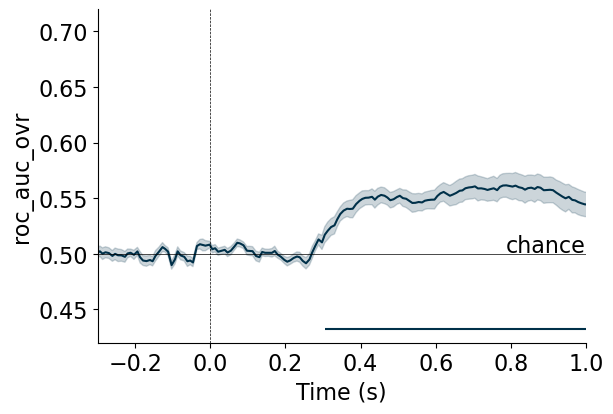

In [118]:
fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_allemos, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.42, 0.72), scoring="roc_auc_ovr"
)

In [123]:
cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "Woman_01", 2: "Woman_04", 3: "Woman_08"},
}

contrasts = [
    ["surprised", "neutral", "angry", "happy"],
    ["angry", "neutral"],
    ["happy", "neutral"],
    ["angry", "surprised"],
]
data_dict_allcontrasts = load_decod_res_per_contrast(
    sub_list_str=sub_list_str,
    contrasts=contrasts,
    scorings=[
        "roc_auc_ovr",
        "roc_auc",
        "roc_auc",
        "roc_auc",
    ],
)

In [130]:
contrasts_str_list = ["_vs_".join([c.lower() for c in contr]) for contr in contrasts]
colors = COLORS()
colors_custom = [colors.COLDICT[c] for c in ("neutral", "angry", "happy", "surprised")]
# ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
palette = {contr: colors_custom[i] for i, contr in enumerate(contrasts_str_list)}

Not checking for difference between conditions (only implemented         for 2 groups).


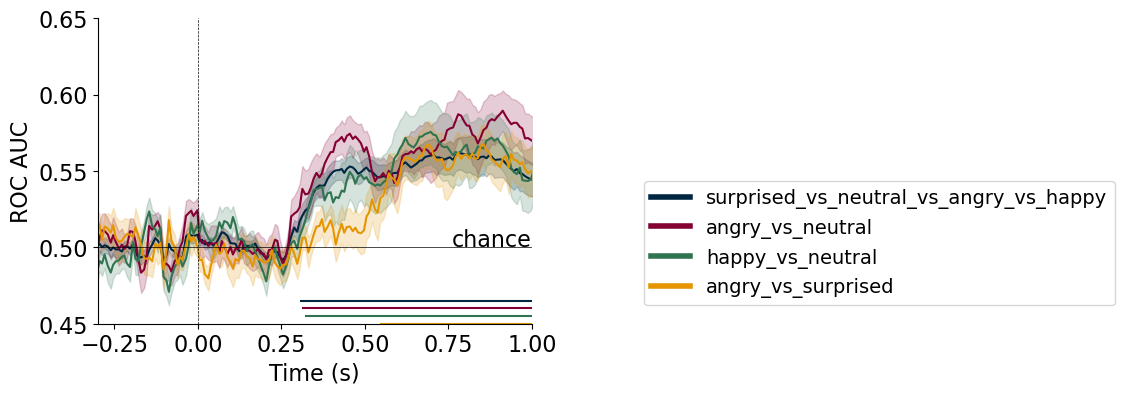

In [131]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))
prep_and_plot_from_data(
    data_dict_allcontrasts,
    subsets=contrasts_str_list,
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)


# save:
fig.savefig(
    Path(paths.FIGURES, "decod_et_allcontrasts.pdf"),
    dpi=300,
    # bbox_inches="tight",
)


#####################################################################################
Found significant difference between conditions! Do you see that?
#####################################################################################



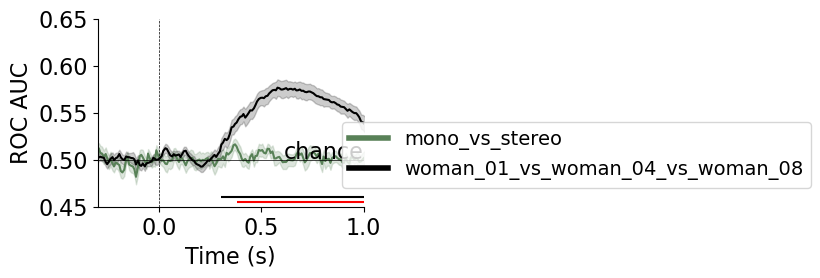

In [132]:
contrasts = [
    ["mono", "stereo"],
    [ava_id.lower() for ava_id in cond_dict["avatar_id"].values()],
]
data_dict_taskirr_contrasts = load_decod_res_per_contrast(
    sub_list_str=sub_list_str,
    contrasts=contrasts,
    scorings=[
        "roc_auc",
        "roc_auc_ovr",
    ],
)

contrasts_str_list = ["_vs_".join([c.lower() for c in contr]) for contr in contrasts]
colors = COLORS()
colors_custom = [colors.COLDICT["viewcond"], "black"]
palette = {contr: colors_custom[i] for i, contr in enumerate(contrasts_str_list)}


fig, ax = plt.subplots(1, figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_taskirr_contrasts,
    subsets=contrasts_str_list,
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)


# save:
fig.savefig(
    Path(paths.FIGURES, "decod_et_taskirr_contrasts.pdf"),
    dpi=300,
    # bbox_inches="tight",
)